<a href="https://colab.research.google.com/github/youngyoung0511/Sound-AI/blob/Data-processing/1114_Onset_DrunSpecialization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# setting

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%%capture
!pip install PyWavelets librosa matplotlib numpy
import librosa
import numpy as np
import matplotlib.pyplot as plt
import pywt


In [3]:
# 필수 라이브러리 설치
!pip install librosa numpy matplotlib


# onset - drum specialization

'/content/drive/My Drive/soundAI/BoysLikeGirls.mp3'

MagicCarpetRide_drum.mp3

Every Day.mp3

music.mp3 //꿈나라별나라


1. 오디오 불러오기

In [8]:
audio_path = '/content/drive/My Drive/soundAI/MagicCarpetRide_drum.mp3'  # 여기에 mp3 파일 경로를 입력하세요
y, sr = librosa.load(audio_path, sr=None)


2. 주파수 변환 적용-cwt

웨이블릿 스케일 조정

In [9]:
# 샘플링 레이트 줄이기
y, sr = librosa.load(audio_path, sr=16000)  # 샘플링 레이트를 16kHz로 다운샘플링


Processing Ride Cymbal with frequency range (300, 4000) Hz...


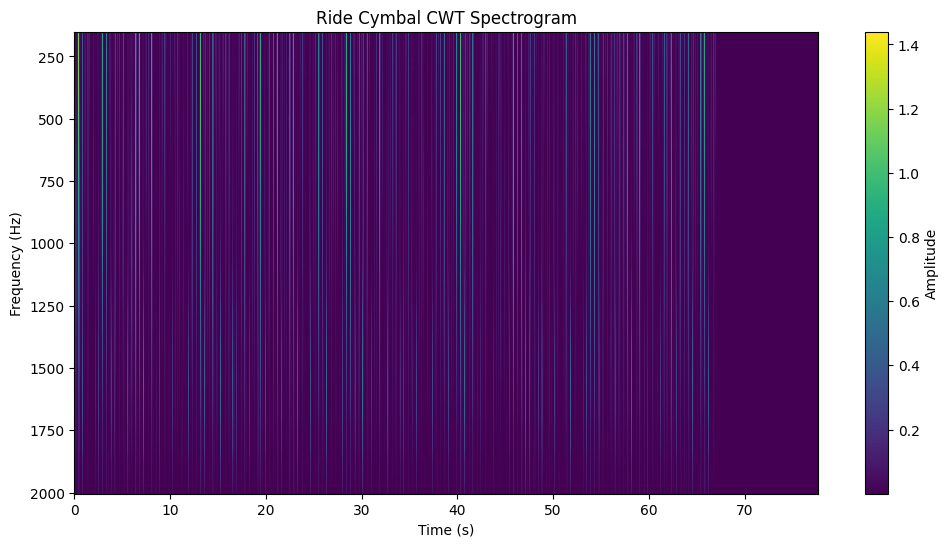

Processing Crash Cymbal with frequency range (400, 8000) Hz...


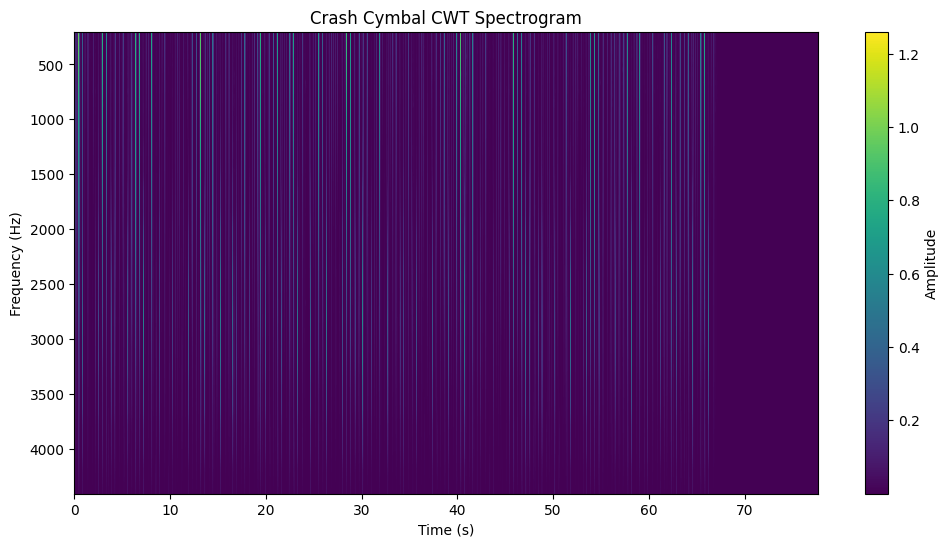

Processing Hi-Hat with frequency range (2000, 8000) Hz...


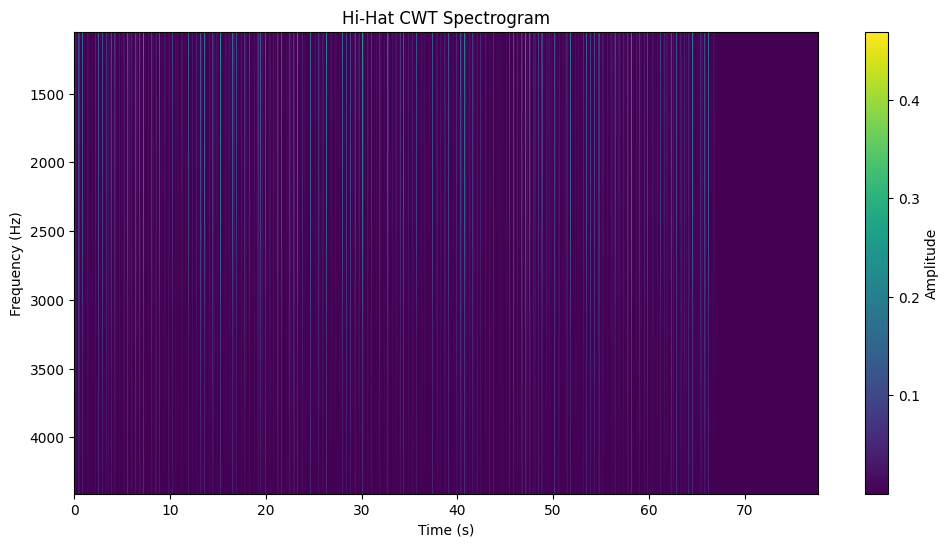

Processing Snare Drum with frequency range (100, 2000) Hz...


In [ ]:
import librosa
import pywt
import numpy as np
import matplotlib.pyplot as plt

# 드럼 요소별 주파수 대역과 스케일 계산 함수
def calculate_scales(freq_range, sr):
    """
    주파수 범위(frequency range)에 맞는 웨이블릿 스케일 계산.
    freq_range: (min_freq, max_freq) 형태의 주파수 범위.
    sr: 샘플링 레이트.
    """
    sampling_interval = 1 / sr  # 샘플링 간격
    center_frequency = 1.0  # cmor 웨이블릿의 중심 주파수 (기본값)

    min_scale = center_frequency / (freq_range[1] * sampling_interval)  # 최대 주파수에 해당하는 스케일
    max_scale = center_frequency / (freq_range[0] * sampling_interval)  # 최소 주파수에 해당하는 스케일

    return np.arange(int(min_scale), int(max_scale))  # 스케일 범위 반환

# 드럼 요소별 주파수 대역 (Hz)
drum_frequencies = {
    "Ride Cymbal": (300, 4000),
    "Crash Cymbal": (400, 8000),
    "Hi-Hat": (2000, 8000),
    "Snare Drum": (100, 2000),
    "Kick Drum": (20, 100),
    "Floor Tom": (50, 200),
    "Mid Tom": (80, 300),
    "High Tom": (100, 400),
}

# 샘플링 레이트 설정
sr = 44100  # 표준 오디오 샘플링 레이트 (Hz)



# 드럼 요소별 CWT 변환
cwt_results = {}
for drum, freq_range in drum_frequencies.items():
    print(f"Processing {drum} with frequency range {freq_range} Hz...")

    # 해당 드럼 요소의 스케일 범위 계산
    scales = calculate_scales(freq_range, sr)

    # CWT 수행
    coefficients, frequencies = pywt.cwt(y, scales, 'cmor', sampling_period=1/sr)
    cwt_results[drum] = (coefficients, frequencies)

    # 결과 시각화
    plt.figure(figsize=(12, 6))
    plt.imshow(np.abs(coefficients), extent=[0, len(y)/sr, frequencies[-1], frequencies[0]],
               aspect='auto', cmap='viridis')
    plt.colorbar(label='Amplitude')
    plt.title(f'{drum} CWT Spectrogram')
    plt.ylabel('Frequency (Hz)')
    plt.xlabel('Time (s)')
    plt.gca().invert_yaxis()  # 주파수 축 반전
    plt.show()


3. PLCA 적용

in) CWT로 얻은 스펙트로그램

1) 각 드럼요소(8개_에 대해 주파수 성분 추출

2) PLCA 적용하여 주파수 성분 / 시계열 성분으로 분리

3) 최적의 주파수 성분을 찾아 시계열 데이터를 기반으로

4) onset 검출

0) 드럼 주파수 대역별로 CWT 변환한 결과를 PLCA에 입력

In [ ]:
import numpy as np

# PLCA 알고리즘 정의
def plca(spectrogram, num_components=8, num_iterations=100):
    """
    PLCA 알고리즘을 사용해 입력 스펙트로그램을 주파수 및 시계열 성분으로 분해합니다.

    Args:
    - spectrogram: 입력 스펙트로그램 (CWT 변환 결과, 비음수 값이어야 함)
    - num_components: 분리할 성분의 개수 (드럼 요소 개수)
    - num_iterations: EM 알고리즘의 반복 횟수

    Returns:
    - freq_components: 주파수 성분 (num_frequencies x num_components)
    - time_components: 시계열 성분 (num_components x num_time_points)
    """
    # 초기화: 주파수 성분과 시계열 성분을 랜덤하게 생성
    num_frequencies, num_time_points = spectrogram.shape
    freq_components = np.random.rand(num_frequencies, num_components)  # 비음수 주파수 성분
    time_components = np.random.rand(num_components, num_time_points)  # 시계열 성분

    for _ in range(num_iterations):
        # E-step: 현재 모델로 입력 스펙트로그램에 대한 확률 계산
        approx = np.dot(freq_components, time_components)  # 복원된 스펙트로그램
        weights = spectrogram / (approx + 1e-9)  # 안정화를 위해 작은 값을 추가

        # M-step: 주파수 및 시계열 성분 업데이트
        freq_components *= np.dot(weights, time_components.T)
        time_components *= np.dot(freq_components.T, weights)

        # 정규화
        freq_components /= np.sum(freq_components, axis=0)
        time_components /= np.sum(time_components, axis=1, keepdims=True)

    return freq_components, time_components

# 예시: 특정 드럼 요소의 CWT 결과 (Kick Drum)
kick_coefficients, kick_frequencies = cwt_results["Kick Drum"]
kick_spectrogram = np.abs(kick_coefficients)  # 절대값을 사용해 비음수 스펙트로그램 생성

# PLCA 적용
freq_components, time_components = plca(kick_spectrogram, num_components=1)

# 주파수 성분 시각화
plt.figure(figsize=(10, 4))
plt.plot(freq_components, label='Kick Drum Frequency Component')
plt.legend()
plt.title('Frequency Component (Kick Drum)')
plt.xlabel('Frequency Index')
plt.ylabel('Amplitude')
plt.show()

# 시계열 성분 시각화
plt.figure(figsize=(10, 4))
plt.plot(time_components.T, label='Kick Drum Temporal Component')
plt.legend()
plt.title('Temporal Component (Kick Drum)')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()


1) 8개의 드럼 요소에 대해 PLCA 적용

In [ ]:
# 8개의 드럼 요소에 대해 PLCA 적용
plca_results = {}
for drum, (coefficients, frequencies) in cwt_results.items():
    print(f"Applying PLCA for {drum}...")
    spectrogram = np.abs(coefficients)  # 비음수 CWT 스펙트로그램
    freq_components, time_components = plca(spectrogram, num_components=1)  # 성분 1개만 추출
    plca_results[drum] = (freq_components, time_components)


2) 최적의 주파수 성분 선택

In [ ]:
# 유클리디안 거리로 최적 주파수 성분 찾기
def find_optimal_frequency(freq_components, other_components):
    """
    다른 드럼 요소와의 유클리디안 거리를 계산하여 가장 차별화되는 주파수 성분을 선택합니다.
    """
    optimal_index = -1
    max_distance = 0

    for i, freq in enumerate(freq_components.T):  # 각 성분에 대해
        distance = 0
        for other in other_components:
            distance += np.linalg.norm(freq - other)
        if distance > max_distance:
            max_distance = distance
            optimal_index = i

    return optimal_index, freq_components[:, optimal_index]

# 다른 드럼 요소와의 비교를 위해 모든 주파수 성분 수집
all_frequency_components = [freq.T for freq, _ in plca_results.values()]

# 각 드럼에 대해 최적 주파수 성분 선택
optimal_freq_components = {}
for drum, (freq_components, _) in plca_results.items():
    optimal_index, optimal_freq = find_optimal_frequency(freq_components, all_frequency_components)
    optimal_freq_components[drum] = optimal_freq
    print(f"{drum}: Optimal frequency component index = {optimal_index}")


3) onset 검출(시계열 성분 기반)

In [ ]:
# Threshold 적용
def apply_threshold(time_series, global_thresh=0.01, relative_thresh=0.2):
    time_series = np.where(time_series > global_thresh, time_series, 0)  # 전역 Threshold
    max_value = np.max(time_series)
    time_series = np.where(time_series > relative_thresh * max_value, time_series, 0)  # 상대 Threshold
    return time_series

# Onset 검출
def detect_onsets(time_series):
    return np.where((time_series > 0) & (np.roll(time_series, 1) == 0))[0]

# 각 드럼 요소의 Onset 검출
onset_results = {}
for drum, (_, time_components) in plca_results.items():
    filtered_signal = apply_threshold(time_components[0])  # 첫 번째 성분
    onsets = detect_onsets(filtered_signal)
    onset_results[drum] = onsets
    print(f"{drum}: Detected onsets at frames {onsets}")
